# A Model for Rankings

In [1]:
# Necessary imports
from ranking_system import *
%matplotlib inline

$r_u(t)$ = the ranking of university $u$ at time $t$.

We'll use $t$ to represent time, which will generally think of
as discrete. Thus $r_u(t-1)$ is university $u$'s ranking the year before.

In [2]:
# Time steps
T = 10

# Universities
U = 2

Let $M$ be the number of attributes in the ranking.

In [3]:
# Attributes
M = 2

$y_{i,u}(t)$ = the value of university $u$'s i-th attribute,
where $i$ ranges from 1 to $M$.

$w_i(t)$ is the weightage given to attribute $i$ in the ranking.
This generally does not change frequently.

In [4]:
# Create weightage functions
# Return the weight used for ranking attribute i at time t
# The sum of the M weightage functions at time t must add up to 1


def weightage_average_spending_per_student(t):
    """Weight given to average spending per student attribute
       Decreases at time t greater than 5"""
    return 0.7 if t < 5 else 0.6


def weightage_average_class_size(t):
    """Weight given to average class size attribute
       Increases at time t greater than 5"""
    return 0.3 if t < 5 else 0.4

The _valuation_ functions $V_i$ need a little explanation.

Think of them as the true valuation of a particular attribute, complete with
lower/upper bounds and potential non-linearities.

For example, consider the attribute "average class size". A ranking could ignore class sizes below 5, and could likewise scale up non-linearly so that a class size of 300 is not much worse than a class size of 200. This means that one could have a step-like $V_i$ function for class sizes to give us the actual value used in the weighted score.

In [5]:
# Create valuation functions
# Return the true valuation of attribute i at time t 


def valuation_average_spending_per_student(average_spending_per_student):
    """Valuation given to the average spending per student attribute"""
    # Step like function for average spending per student
    if average_spending_per_student > 10_000:
        # Spending more than 10,000 per student receives the most credit
        return 100
    elif average_spending_per_student > 7_500:
        # Spending between 7,500 and 10,000 per student scores second highest
        return 75
    elif average_spending_per_student < 5_000:
        # Spending between 5,000 and 7,500 per student scores third highest
        return 50
    elif average_spending_per_student < 2_500:
        # Spending between 2,500 and 5,000 per student scores fourth highest
        return 25
    else:
        # Spending less than 2,500 per student receives no credit
        return 0

    
def valuation_average_class_size(average_class_size):
    """Valuation given to the average class size attribute"""
    # Step like function for average class size
    if average_class_size < 20:
        # Classes with fewer than 20 students receive the most credit
        return 100
    elif average_class_size < 30:
        # Classes with 20 to 29 students score second highest
        return 75
    elif average_class_size < 40:
        # Classes with 30 to 39 students score third highest
        return 50
    elif average_class_size < 50:
        # Classes with 40 to 49 students score fourth highest
        return 25
    else:
        # Classes that are 50 or more students receive no credit
        return 0

Define the _production_ functions $P_{i,u}$ as

   $$
        y_{i,u}(t) = P_{i,u}( x_{i,u}(t) )
   $$

Here, the idea is to model non-linearities. 

Simply adding dollars does not decrease class-sizes linearly.

There may be floors, ceilings or other non-linearities, and universities will differ in these "bang-for-the-buck" functions.

In [6]:
# Create production functions


def production_average_spending_per_student(dollars, random):
    """Production function for the average spending per student attribute"""
    # Educational: spending on instruction, research, and student services
    # Non-educational: spending on sports, dorms, and hospitals
    # Universities will differ in the percentage of dollars spent on educational
    # versus non-educational resources.
    # The educational spending percentage may change from year to year.
    educational_spending_percentage = random.uniform(0.5, 1)
    return dollars * educational_spending_percentage


def production_average_class_size(dollars, random):
    """Production function for the average class size attribute"""
    if dollars > random.uniform(9_000, 10_000):
        return 10
    elif dollars > random.uniform(6_000, 9_000):
        return 20
    elif dollars > random.uniform(3_000, 6_000):
        return 30
    elif dollars > random.uniform(2_000, 3_000):
        return 40
    elif dollars > random.uniform(1_000, 2_000):
        return 50
    elif dollars > random.uniform(500, 1_000):
        return 100
    else:
        return 200

In [7]:
# Create a list of M attributes 
# Parameters: name, weightage function, valuation function, production function

attributes = [Attribute('Average Spending Per Student',
                        weightage_average_spending_per_student,
                        valuation_average_spending_per_student,
                        production_average_spending_per_student),
              Attribute('Average Class Size',
                        weightage_average_class_size,
                        valuation_average_class_size,
                        production_average_class_size)]

We will now define the _score_ of a university as

$$
     \mu_u(t) = \sum_{i} w_i(t) V_i(y_{i,u}(t))
$$

The ranking then, is just an ordering of the universities in epoch
$t$ using their $\mu_u(t)$ values.

,University,Time,Rank,Score,Normalized Score,Funding 1,Funding 2
0,University 1,1,2,35.0,58,5014.67,1122.82
1,University 2,1,1,60.0,100,9613.51,4435.33
2,University 1,2,1,52.5,100,10198.35,583.69
3,University 2,2,2,42.5,81,856.20,3034.86
...,...,...,...,...,...,...,...
16,University 1,9,2,0.0,0,12395.06,985.23
17,University 2,9,1,50.0,100,4794.31,6840.42
18,University 1,10,1,60.0,100,1824.26,8652.14
19,University 2,10,2,0.0,0,6229.45,961.62


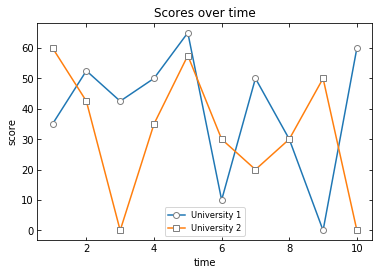

In [8]:
# Create a new model
model = RankingModel(U, attributes, random_seed=13579)

# Run the model
model.run(T)

# Display the scores and ranking
display_ranking(model, all_rows=False)

# Plot the university score over time
line_plot(find_values_by_agent(model, 'score'), 'time', 'score', 'Scores over time')